The noise model below randomly flips each bit with probability `p`

In [1]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble

In [12]:
noise_model = get_noise(0.01)
# Investigate measurements of 2-qubit product states with noise
qasm_sim = Aer.get_backend('qasm_simulator')
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)
    qc.h(0)
    qc.cx(0,1)  
    qc.measure([0,1], [0,1])
    t_qc = transpile(qc, qasm_sim)
    qobj = assemble(t_qc)
    counts = qasm_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()
    print(state+' becomes', counts)

00 becomes {'01': 996, '10': 991, '00': 49100, '11': 48913}
01 becomes {'01': 1012, '10': 978, '00': 48858, '11': 49152}
10 becomes {'01': 49139, '11': 987, '00': 991, '10': 48883}
11 becomes {'01': 48589, '11': 970, '00': 981, '10': 49460}


In [13]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [14]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
         ░ ┌─┐   
q272_0: ─░─┤M├───
         ░ └╥┘┌─┐
q272_1: ─░──╫─┤M├
         ░  ║ └╥┘
  c0: 2/════╩══╩═
            0  1 

Circuit mcalcal_01
        ┌───┐ ░ ┌─┐   
q272_0: ┤ X ├─░─┤M├───
        └───┘ ░ └╥┘┌─┐
q272_1: ──────░──╫─┤M├
              ░  ║ └╥┘
  c0: 2/═════════╩══╩═
                 0  1 

Circuit mcalcal_10
              ░ ┌─┐   
q272_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
q272_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
  c0: 2/═════════╩══╩═
                 0  1 

Circuit mcalcal_11
        ┌───┐ ░ ┌─┐   
q272_0: ┤ X ├─░─┤M├───
        ├───┤ ░ └╥┘┌─┐
q272_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
  c0: 2/═════════╩══╩═
                 0  1 



In [15]:
# Execute the calibration circuits without noise
t_qc = transpile(meas_calibs, qasm_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = qasm_sim.run(qobj, shots=10000).result()

In [17]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

In [19]:
meas_fitter.cal_matrix

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [20]:
noise_model = get_noise(0.1)

In [21]:
t_qc = transpile(meas_calibs, qasm_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = qasm_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_fitter.cal_matrix

array([[0.8125, 0.0897, 0.0928, 0.0099],
       [0.0913, 0.8136, 0.0087, 0.0863],
       [0.0859, 0.0093, 0.805 , 0.09  ],
       [0.0103, 0.0874, 0.0935, 0.8138]])

In [22]:
import scipy.linalg as la
Minv = la.inv(meas_fitter.cal_matrix)
Minv

array([[ 1.26161025, -0.13909482, -0.14573719,  0.01552014],
       [-0.14169605,  1.25889143,  0.01826961, -0.13379676],
       [-0.13463254,  0.01541573,  1.27395362, -0.14088639],
       [ 0.01471835, -0.13521234, -0.14648603,  1.25916301]])

In [23]:
Minv.dot(meas_fitter.cal_matrix)

array([[ 1.00000000e+00, -2.78564154e-17,  1.59249943e-18,
         2.99819813e-18],
       [-7.32963593e-18,  1.00000000e+00,  1.05666515e-18,
        -3.43450222e-17],
       [ 2.34358206e-17,  2.84143706e-18,  1.00000000e+00,
        -1.15351398e-17],
       [ 8.38000498e-19,  5.07936138e-18, -2.55926753e-17,
         1.00000000e+00]])

In [32]:
from numpy import array
raw_counts = array([list(row.values()) for row in cal_results.get_counts()])

In [33]:
raw_counts

array([[ 913,  103,  859, 8125],
       [  93,  897,  874, 8136],
       [  87,  928,  935, 8050],
       [ 863,   99,  900, 8138]])

In [34]:
Minv.dot(raw_counts)

array([[1139.62907938, -128.52981525,  839.85818115, 8072.02630627],
       [-126.16873904, 1118.33923478,  875.2192004 , 8149.29256141],
       [-132.23683638, 1168.24196364,  962.17287834, 8140.32617841],
       [1074.77649604, -131.05138317,  890.7497401 , 8087.35495392]])

In [36]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(cal_results)
mitigated_counts = mitigated_results.get_counts()

In [37]:
mitigated_counts

[{'00': 9999.999999096868, '11': 1.6865267294385866e-06},
 {'01': 9999.99999926187, '10': 1.3218487851518468e-06},
 {'01': 5.561766908412924e-07, '10': 9999.999999746027},
 {'10': 6.153966225497243e-13, '11': 10000.0}]

In [42]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure([0,1], [0,1])

noise_model = get_noise(0.1)
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc, shots=10000)
results = qasm_sim.run(qobj, noise_model=noise_model, shots=10000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'01': 908, '10': 904, '00': 4051, '11': 4137}


In [43]:
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()
print(mitigated_counts)

{'00': 4916.94558536617, '01': 32.06171661058067, '10': 37.40771047768974, '11': 5013.58498754556}


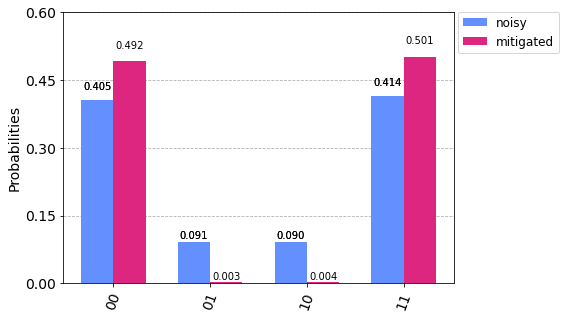

In [44]:
from qiskit.visualization import plot_histogram 
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [45]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}